In [5]:
import sys
import numpy as np
from collections import defaultdict
import matlab.engine
import time
import os
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import random
print("Loaded")

ModuleNotFoundError: No module named 'matlab.engine'; 'matlab' is not a package

In [6]:
EPSILON = 0.0001
 
FAIRLETS = []
FAIRLET_CENTERS = []
 
class TreeNode:
 
    def __init__(self):
        self.children = []
 
    def set_cluster(self, cluster):
        self.cluster = cluster
 
    def add_child(self, child):
        self.children.append(child)
 
    def populate_colors(self, colors):
        "Populate auxiliary lists of red and blue points for each node, bottom-up"
        self.reds = []
        self.blues = []
        if len(self.children) == 0:
            # Leaf
            for i in self.cluster:
                if colors[i] == 0:
                    self.reds.append(i)
                else:
                    self.blues.append(i)
        else:
            # Not a leaf
            for child in self.children:
                child.populate_colors(colors)
                self.reds.extend(child.reds)
                self.blues.extend(child.blues)
 
 

In [7]:

### K-MEDIAN CODE ###
 
def kmedian_cost(points, centroids, dataset):
    "Computes and returns k-median cost for given dataset and centroids"
    return sum(np.amin(np.concatenate([np.linalg.norm(dataset[:,:]-dataset[centroid,:], axis=1).reshape((dataset.shape[0], 1)) for centroid in centroids], axis=1), axis=1))


In [8]:

def fair_kmedian_cost(centroids, dataset):
    "Return the fair k-median cost for given centroids and fairlet decomposition"
    total_cost = 0
    for i in range(len(FAIRLETS)):
        # Choose index of centroid which is closest to the i-th fairlet center
        cost_list = [np.linalg.norm(dataset[centroids[j],:]-dataset[FAIRLET_CENTERS[i],:]) for j in range(len(centroids))]
        cost, j = min((cost, j) for (j, cost) in enumerate(cost_list))
        # Assign all points in i-th fairlet to above centroid and compute cost
        total_cost += sum([np.linalg.norm(dataset[centroids[j],:]-dataset[point,:]) for point in FAIRLETS[i]])
    return total_cost
 

In [9]:

 
### FAIRLET DECOMPOSITION CODE ###
 
def balanced(p, q, r, b):
    if r==0 and b==0:
        return True
    if r==0 or b==0:
        return False
    return min(r*1./b, b*1./r) >= p*1./q
 
 

In [10]:

def make_fairlet(points, dataset):
    "Adds fairlet to fairlet decomposition, returns median cost"
    FAIRLETS.append(points)
   # print(dataset)
    cost_list = [sum([np.linalg.norm(dataset[center,:]-dataset[point,:]) for point in points]) for center in points]
    cost, center = min((cost, center) for (center, cost) in enumerate(cost_list))
    FAIRLET_CENTERS.append(points[center])
    return cost
 

In [11]:

 
def basic_fairlet_decomposition(p, q, blues, reds, dataset):
    """
    Computes vanilla (p,q)-fairlet decomposition of given points (Lemma 3 in NIPS17 paper).
    Returns cost.
    Input: Balance parameters p,q which are non-negative integers satisfying p<=q and gcd(p,q)=1.
    "blues" and "reds" are sets of points indices with balance at least p/q.
    """
    assert p <= q, "Please use balance parameters in the correct order"
    if len(reds) < len(blues):
        temp = blues
        blues = reds
        reds = temp
    R = len(reds)
    B = len(blues)
    assert balanced(p, q, R, B), "Input sets are unbalanced: "+str(R)+","+str(B)
 
    if R==0 and B==0:
        return 0
 
    b0 = 0
    r0 = 0
    cost = 0
    while (R-r0)-(B-b0) >= q-p and R-r0 >= q and B-b0 >= p:
        cost += make_fairlet(reds[r0:r0+q]+blues[b0:b0+p], dataset)
        r0 += q
        b0 += p
    if R-r0 + B-b0 >=1 and R-r0 + B-b0 <= p+q:
        cost += make_fairlet(reds[r0:]+blues[b0:], dataset)
        r0 = R
        b0 = B
    elif R-r0 != B-b0 and B-b0 >= p:
        cost += make_fairlet(reds[r0:r0+(R-r0)-(B-b0)+p]+blues[b0:b0+p], dataset)
        r0 += (R-r0)-(B-b0)+p
        b0 += p
    assert R-r0 == B-b0, "Error in computing fairlet decomposition"
    for i in range(R-r0):
        cost += make_fairlet([reds[r0+i], blues[b0+i]], dataset)
    return cost
 
 

In [8]:

def node_fairlet_decomposition(p, q, node, dataset, donelist, depth):

    # Leaf                                                                                          
    if len(node.children) == 0:
        node.reds = [i for i in node.reds if donelist[i]==0]
        node.blues = [i for i in node.blues if donelist[i]==0]
        assert balanced(p, q, len(node.reds), len(node.blues)), "Reached unbalanced leaf"
        return basic_fairlet_decomposition(p, q, node.blues, node.reds, dataset)
 
    # Preprocess children nodes to get rid of points that have already been clustered
    for child in node.children:
        child.reds = [i for i in child.reds if donelist[i]==0]
        child.blues = [i for i in child.blues if donelist[i]==0]
 
    R = [len(child.reds) for child in node.children]
    B = [len(child.blues) for child in node.children]
 
    if sum(R) == 0 or sum(B) == 0:
        assert sum(R)==0 and sum(B)==0, "One color class became empty for this node while the other did not"
        return 0
 
    NR = 0
    NB = 0
 
    # Phase 1: Add must-remove nodes
    for i in range(len(node.children)):
        if R[i] >= B[i]:
            must_remove_red = max(0, R[i] - int(np.floor(B[i]*q*1./p)))
            R[i] -= must_remove_red
            NR += must_remove_red
        else:
            must_remove_blue = max(0, B[i] - int(np.floor(R[i]*q*1./p)))
            B[i] -= must_remove_blue
            NB += must_remove_blue
 
    # Calculate how many points need to be added to smaller class until balance
    if NR >= NB:
        # Number of missing blues in (NR,NB)
        missing = max(0, int(np.ceil(NR*p*1./q)) - NB)
    else:
        # Number of missing reds in (NR,NB)
        missing = max(0, int(np.ceil(NB*p*1./q)) - NR)
         
    # Phase 2: Add may-remove nodes until (NR,NB) is balanced or until no more such nodes
    for i in range(len(node.children)):
        if missing == 0:
            assert balanced(p, q, NR, NB), "Something went wrong"
            break
        if NR >= NB:
            may_remove_blue = B[i] - int(np.ceil(R[i]*p*1./q))
            remove_blue = min(may_remove_blue, missing)
            B[i] -= remove_blue
            NB += remove_blue
            missing -= remove_blue
        else:
            may_remove_red = R[i] - int(np.ceil(B[i]*p*1./q))
            remove_red = min(may_remove_red, missing)
            R[i] -= remove_red
            NR += remove_red
            missing -= remove_red
 
    # Phase 3: Add unsatuated fairlets until (NR,NB) is balanced
    for i in range(len(node.children)):
        if balanced(p, q, NR, NB):
            break
        if R[i] >= B[i]:
            num_saturated_fairlets = int(R[i]/q)
            excess_red = R[i] - q*num_saturated_fairlets
            excess_blue = B[i] - p*num_saturated_fairlets
        else:
            num_saturated_fairlets = int(B[i]/q)
            excess_red = R[i] - p*num_saturated_fairlets
            excess_blue = B[i] - q*num_saturated_fairlets
        R[i] -= excess_red
        NR += excess_red
        B[i] -= excess_blue
        NB += excess_blue
 
    assert balanced(p, q, NR, NB), "Constructed node sets are unbalanced"
 
    reds = []
    blues = []
    for i in range(len(node.children)):
        for j in node.children[i].reds[R[i]:]:
            reds.append(j)
            donelist[j] = 1
        for j in node.children[i].blues[B[i]:]:
            blues.append(j)
            donelist[j] = 1
 
    assert len(reds)==NR and len(blues)==NB, "Something went horribly wrong"
 
    return basic_fairlet_decomposition(p, q, blues, reds, dataset) + sum([node_fairlet_decomposition(p, q, child, dataset, donelist, depth+1) for child in node.children])
 

In [9]:

 
def tree_fairlet_decomposition(p, q, root, dataset, colors):
    "Main fairlet clustering function, returns cost wrt original metric (not tree metric)"
    assert p <= q, "Please use balance parameters in the correct order"
    root.populate_colors(colors)
    assert balanced(p, q, len(root.reds), len(root.blues)), "Dataset is unbalanced"
    root.populate_colors(colors)
    donelist = [0] * dataset.shape[0]
    return node_fairlet_decomposition(p, q, root, dataset, donelist, 0)
 
 

In [10]:

### QUADTREE CODE ###
 
def build_quadtree(dataset, max_levels=0, random_shift=True):
    "If max_levels=0 there no level limit, quadtree will partition until all clusters are singletons"
    dimension = dataset.shape[1]
    lower = np.amin(dataset, axis=0)
    upper = np.amax(dataset, axis=0)
 
    shift = np.zeros(dimension)
    if random_shift:
        for d in range(dimension):
            spread = upper[d] - lower[d]
            shift[d] = np.random.uniform(0, spread)
            upper[d] += spread
 
    return build_quadtree_aux(dataset, range(dataset.shape[0]), lower, upper, max_levels, shift)
     
 

In [11]:

def build_quadtree_aux(dataset, cluster, lower, upper, max_levels, shift):
    """
    "lower" is the "bottom-left" (in all dimensions) corner of current hypercube
    "upper" is the "upper-right" (in all dimensions) corner of current hypercube
    """
 
    dimension = dataset.shape[1]
    cell_too_small = True
    for i in range(dimension):
        if upper[i]-lower[i] > EPSILON:
            cell_too_small = False
 
    node = TreeNode()
    if max_levels==1 or len(cluster)<=1 or cell_too_small:
        # Leaf
        node.set_cluster(cluster)
        return node
     
    # Non-leaf
    midpoint = 0.5 * (lower + upper)
    subclusters = defaultdict(list)
    for i in cluster:
        subclusters[tuple([dataset[i,d]+shift[d]<=midpoint[d] for d in range(dimension)])].append(i)
    for edge, subcluster in subclusters.items():
        sub_lower = np.zeros(dimension)
        sub_upper = np.zeros(dimension)
        for d in range(dimension):
            if edge[d]:
                sub_lower[d] = lower[d]
                sub_upper[d] = midpoint[d]
            else:
                sub_lower[d] = midpoint[d]
                sub_upper[d] = upper[d]
        node.add_child(build_quadtree_aux(dataset, subcluster, sub_lower, sub_upper, max_levels-1, shift))
    return node
 
 

**DIABETES DATASET** 

In [12]:

def load_diabetes(data_dir=''):

    data_dir = 'Datasets/'
    _path = 'diabetic_data.csv'
    data_path = os.path.join(data_dir, _path)
  
    df = pd.read_csv(data_path, sep=',', header=[0])
    n = df.shape[0]
    #print(df.head())
    df = df.iloc[:,[3,4,9]]
    age_ = []
    gender_ =[]
    for index, row in df.iterrows():
        s = row['age']
        s = s[1:-1]
        a,b= s.split("-")
        age_.append((int(a)+int(b))//2);
        
        if row['gender']=='Female':
            gender_.append(1)
        else:
            gender_.append(0)
            
        
    df['age']=age_;
   # df['gender']=gender_;
    df=df.drop(4)
    #print(df.head())
    df=df.iloc[:,[1,2]]
        
    return  df.to_numpy(), np.array(gender_)

#load_diabetes()



**BANK DATASET** 

*Step 1: Data Preprocessing* 

In [33]:
#binary Bank 
def load_bank(data_dir=''):

    data_dir = 'Datasets'
    _path = 'bank.csv'
    data_path = os.path.join(data_dir, _path)
      
    df = pd.read_csv(data_path, sep=',', header=[0])
    df1 = df.loc[df['marital'] == 'married']
    df2 = df.loc[df['marital'] == 'single']
    df3 = df.loc[df['marital'] =='divorced']
    
    
    df = [df1, df2, df3]
    df = pd.concat(df)
    n = df.shape[0]
    
    sex = df['marital']
    sens_attributes = list(set(sex.astype(str).values))  
    sex_num = np.zeros(n, dtype=int)
    sex_num[sex.astype(str).values == 'married'] = 1  

    df = df.iloc[:, [0,5,11]]
    return  df.to_numpy(),sex_num
   
#load_bank()



**CENSUS DATASET** 

*Step 1: Data Preprocessing* 

In [13]:

def load_census(data_dir=''):

    #data_dir = 'PycharmProjects/Fair_clustering_EF1/Datasets_minor/'
    _path = 'adult_p.csv'
    data_path = os.path.join(data_dir, _path)

    df = pd.read_csv(data_path, sep=',', header=[0])
    n = df.shape[0]
    
    sex_num = df['gender']
        
    df = df.drop(columns=['gender'])
   
    return  df.to_numpy(),np.array(sex_num)

load_census()
print("done")


done


**CENSUS II DATASET** 

*Step 1: Data Preprocessing* 

In [12]:
 
def load_censusII(data_dir=''):

    data_dir = 'PycharmProjects/Fair_clustering_EF1/Datasets_minor/'
    _path = 'USCensus1990raw.data.txt'
    data_path = os.path.join(data_dir, _path)

    df = pd.read_csv(data_path, sep='\t', header=None)
    n = df.shape[0]
    sex_num = df.iloc[:, 112].astype(int)

    selected_attributes = [12, 35, 36, 47, 53, 54, 55, 58, 60, 63, 64, 65, 73, 80, 81, 93, 94, 95, 96, 101, 109, 116,
                           118, 122, 124]

    
  
    df = df.iloc[:,selected_attributes]

    #df['type'] = sex_num
    
    #df = df.iloc[:,[25,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]]
    return df.to_numpy(), sex_num.to_numpy()

#load_censusII()

*Step 2: Fair Clustering* 

In [13]:
def truncate(f, n):
    return math.floor(f * 10 ** n) / 10 ** n

In [14]:
def load_dataset(dataset_name):
    if dataset_name=='diabetes':
        dataset,colors_ = load_diabetes()
    elif dataset_name=='census':
        dataset,colors_ = load_census()
    elif dataset_name=='censusII':
        dataset,colors_ = load_censusII()
    elif dataset_name=='bank':
        dataset,colors_ = load_bank()
    else:
        print('Using Randomised dataset')
        n_points = 1000
        dimension = 5
        dataset = np.random.random((n_points, dimension))
        colors_ = [np.random.randint(2) for i in range(n_points)]

    return dataset,colors_

In [15]:

def compute(p,q,k,dataset,colors_,sample_size,subSample):
    
    
    p = min(p,q)
    q = max(p,q)
    
    n_points = len(dataset)
    
    #print( p )
    #print(q)
    fairlet_s = time.time()
    
    if  subSample==False:
        idx = np.arange(n_points)
        np.random.shuffle(idx)
        sample_size=n_points
        idx = idx[:sample_size]
        n_points = sample_size
        dataset = dataset[idx,:]
        colors = [colors_[i] for i in idx]
    else:
        iter =100
        temp = len(dataset)
        temp_dataset = dataset
        while iter>=0:
            n_points = temp
            dataset = temp_dataset
            idx = np.arange(n_points)
          #  print('Npoints is '+str(n_points))
           # print('Sample size is '+str(sample_size))
           # np.random.seed(quantumrandom.get_data())
            random.shuffle(idx)
            random.shuffle(idx)
            random.shuffle(idx)
            random.shuffle(idx)
            #print(random.random())
                      
            idx = idx[:sample_size]
           # print(idx)
            n_points = sample_size
            dataset = dataset[idx,:]
            colors = [colors_[i] for i in idx]
            a = len([ 1 for x in colors if x==1])
            b = len([ 1 for x in colors if x==0])
            #print('a '+str(a))
            #print('b '+str(b))
            c1 = a/b
            c2 = b/a
            t1 = truncate(c1,2)
            t2 = truncate(c2,2)
            t = min(t1,t2)
            tt = truncate(p/q,2)
            #print(t)
            #print(tt)
            if t == tt:
                break
            else: 
                #print('-------------------------------Sampling again : '+str(iter))
                #import time  as timr
                #timr.sleep(30) 
                iter = iter-1

    dimension = dataset[0].shape
    #print(dataset.shape)
    #print(len(colors))
    a = [ 1 for x in colors if x==1]
    b = [ 1 for x in colors if x==0]
  #  print("A "+str(len(a)))
   # print("B "+str(len(b)))
    
  #  print("Number of data points:", n_points)
   # print("Dimension:", dimension)
   # print("Balance:", p, q)

    #print("Constructing tree...")
  
    root = build_quadtree(dataset)

    #print("Doing fair clustering...")
  #  print('Beofe = '+str(dataset.shape))
   # print(dataset)
    cost = tree_fairlet_decomposition(p, q, root, dataset, colors)
    #print("Fairlet Decomposition Runtime: ", str(fairlet_time));
    #print("Doing k-median clustering on fairlet centers...")
    fairlet_center_idx = [dataset[index] for index in FAIRLET_CENTERS]
    fairlet_center_pt = np.array([np.array(xi) for xi in fairlet_center_idx])

    # convert points into matlab array format
    mat_matrix = matlab.double(fairlet_center_pt.tolist())
    
    fairlet_e = time.time()

    #print("Fairlet decomposition cost:", cost)
    fairlet_time = fairlet_e-fairlet_s;
   
    # Run k-mediod code in Matlab
    cluster_s = time.time()
    eng = matlab.engine.start_matlab()
    # C: Cluster medoid locations, returned as
    # a numeric matrix.
    # C is a k-by-d matrix, where row j is the medoid of cluster j
    #
    # midx: Index to mat_matrix, returned as a column vector of indices.
    # midx is a k-by-1 vector and the indices satisfy C = X(midx,:)
    idx,C,sumd,D,midx,info = eng.kmedoids(mat_matrix,k,'Distance','sqeuclidean', nargout=6)
    np_idx = (np.array(idx._data)).flatten()
    
    #print("Total Runtime: ", str(total_runtime));

    # compute the indices of centers returned by Matlab in its input matrix
    # which is mat_matrix or fairlet_center_pt
    np_midx = (np.array(midx._data)).flatten()
    c_idx_matrix = np_midx.astype(int)
    #in matlab, arrays are numbered from 1
    c_idx_matrix[:] = [index - 1 for index in c_idx_matrix]

    # indices of center points in dataset
    centroids = [FAIRLET_CENTERS[index] for index in c_idx_matrix]

    #print("Computing fair k-median cost...")
    kmedian_cost = fair_kmedian_cost(centroids, dataset)
    #print("Fairlet decomposition cost:", cost)
    #print("k-Median cost:", kmedian_cost)
    cluster_e = time.time()
    total_runtime = (fairlet_e-fairlet_s) + (cluster_e-cluster_s)
    
    return kmedian_cost,cost, fairlet_time, total_runtime

    

Collecting Analytics for different sample size 

In [16]:

p = 9
q = 20
#k =10

dataset, colors_ = load_dataset('census')
step_size = len(dataset)
print("Length : "+str(step_size))
total_size = len(dataset)
for k in [2,5,10,15,20,30,40]:
    kmed=[]
    fcost=[]
    fTime=[]
    tTime=[]
    iter_no =[]
    print('*'*50)
    print("K == "+str(k))
    print("*"*50)
    for sample_size in range(step_size,step_size+1, step_size):
        #Subsample each sample size 10 times to find average for that value
        seeds = [0,100,200,300,400,500,600,700,800,900,1000,1100]

        for i in range(0,10):
            #print("-"*50)
            print('Run No : '+str(i))
            np.random.seed(seeds[i])
            random.seed(i)
           # print("***************---iteration: " +str(i)+"  -----******************")
            FAIRLETS.clear()
            FAIRLET_CENTERS.clear()
            kmedian_cost,cost, fairlet_time, total_runtime = compute(p,q,k,dataset,colors_,sample_size,False)
            kmed.append(kmedian_cost)
            fcost.append(cost)
            fTime.append(fairlet_time)
            tTime.append(total_runtime)
            iter_no.append(i)
            print('Fairlet Decomposition Cost '+str((cost)))
            print('K-median Cost '+str((kmedian_cost)))
            print('Fairlet Decomposition RunTime '+str((fairlet_time)))
            print('Total RunTime '+str((total_runtime)))
            print("*************************************************************\n")

        kmed=np.array(kmed)
        fcost = np.array(fcost)
        fTime=np.array(fTime)
        tTime=np.array(tTime)
        iter_no = np.array(iter_no)
        print("Overall Results for 10 Runs: \n")
        print('Mean Fairlet Decomposition Cost '+str(np.mean(fcost)))
        print('Mean K-median Cost '+str(np.mean(kmed)))
        print('Mean Fairlet Decomposition RunTime '+str(np.mean(fTime)))
        print('Mean Total RunTime '+str(np.mean(tTime)))
        print("*************************************************************\n")

        print('Std Dev. Fairlet Decomposition Cost '+str(np.std(fcost)))
        print('Std Dev. K-median Cost '+str(np.std(kmed)))
        print('Std Dev. Fairlet Decomposition RunTime '+str(np.std(fTime)))
        print('Std Dev. Total RunTime '+str(np.std(tTime)))
        print("*************************************************************\n")



NameError: name 'load_census' is not defined

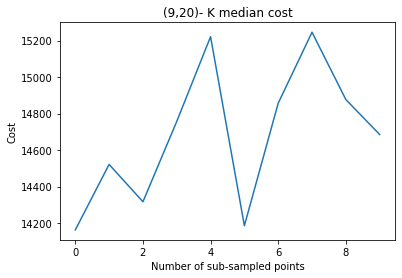

In [19]:

plt.plot(iter_no, kmed) 
plt.xlabel("Number of sub-sampled points") 
plt.ylabel("Cost") 
title = "(" + str(p)+ "," + str(q) +")" + "- K median cost";
plt.title(title)
plt.show() 

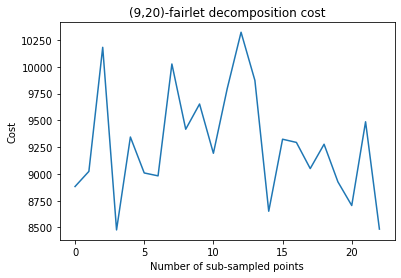

In [23]:

plt.plot(iter_no, fcost) 
plt.xlabel("Number of sub-sampled points") 
plt.ylabel("Cost") 
title = "(" + str(p)+ "," + str(q) +")" + "-fairlet decomposition cost";
plt.title(title)
plt.show() 

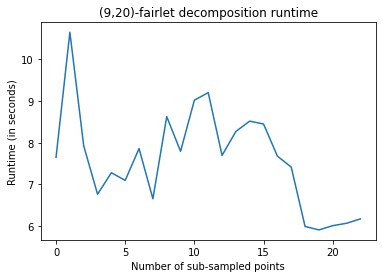

In [24]:

plt.plot(iter_no, fTime) 
plt.xlabel("Number of sub-sampled points") 
plt.ylabel("Runtime (in seconds)") 
title = "(" + str(p)+ "," + str(q) +")" + "-fairlet decomposition runtime";
plt.title(title)
plt.show() 

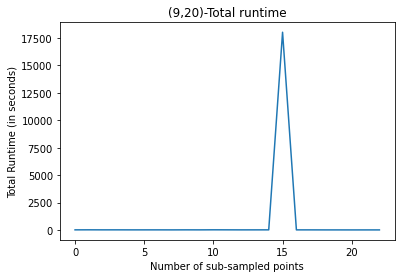

In [25]:

plt.plot(iter_no, tTime) 
plt.xlabel("Number of sub-sampled points") 
plt.ylabel("Total Runtime (in seconds)") 
title = "(" + str(p)+ "," + str(q) +")" + "-Total runtime";
plt.title(title)
plt.show() 

In [26]:
print("Minimum K-Median cost  "+str(min(kmed)))
print("Minimum Fairlet cost  "+str(min(fcost)))
print("Minimum Fairlet RUntime  "+str(min(fTime)))
print("Minimum TOtal RUntime  "+str(min(tTime)))

Minimum K-Median cost  19663.336126007067
Minimum Fairlet cost  8476.989277494362
Minimum Fairlet RUntime  5.906198024749756
Minimum TOtal RUntime  11.809336423873901


In [27]:
print("Minimum K-Median cost  "+str(np.mean(np.array(kmed))))
print("Minimum Fairlet cost  "+str(np.mean(np.array(fcost))))
print("Minimum Fairlet RUntime  "+str(np.mean(np.array(fTime))))
print("Minimum TOtal RUntime  "+str(np.mean(np.array(tTime))))

Minimum K-Median cost  20448.17820981198
Minimum Fairlet cost  9277.376451638167
Minimum Fairlet RUntime  7.595322018084318
Minimum TOtal RUntime  799.08104396903


In [28]:

print("Kmedian cost\n")
print(kmed)

print("Fairlet Decomp cost\n")
print(fcost)

print("Fairlet Runtime\n")
print(fTime)

print("TOtal runtime\n")
print(tTime)

Kmedian cost

[20021.705914619637, 20038.9930324592, 21319.83807958483, 19790.7577322191, 20326.07537285116, 20482.020116236952, 20233.32058587031, 21092.482472200405, 20013.27569351658, 20471.885506553168, 20855.349885857224, 21085.16947384355, 20986.804779671394, 21370.35659406034, 19876.450432538408, 21043.04443150566, 20649.406372654044, 20427.1408981018, 19827.42657722245, 20283.340810353144, 19762.896419947054, 20687.021517802084, 19663.336126007067]
Fairlet Decomp cost

[8882.153476941883, 9023.522064463968, 10182.157570964479, 8476.989277494362, 9344.453974056367, 9008.980511098423, 8981.812294173396, 10026.36973167325, 9417.137942948213, 9652.688484687276, 9192.731708614614, 9796.61827310238, 10322.853480881358, 9872.827605322223, 8651.419056054005, 9323.915244412772, 9294.041832563269, 9049.754345331812, 9276.999250309189, 8926.09559420106, 8704.70041984713, 9486.818379026721, 8484.617869509722]
Fairlet Runtime

[7.650447607040405, 10.652602195739746, 7.9253058433532715, 6.76

In [29]:
print("Minimum K-Median cost  "+str(np.mean(np.array(kmed))))
print("Minimum Fairlet cost  "+str(np.mean(np.array(fcost))))
print("Minimum Fairlet RUntime  "+str(np.mean(np.array(fTime))))
print("Minimum TOtal RUntime  "+str(np.mean(np.array(tTime))))

Minimum K-Median cost  20448.17820981198
Minimum Fairlet cost  9277.376451638167
Minimum Fairlet RUntime  7.595322018084318
Minimum TOtal RUntime  799.08104396903
